In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
import json
from tqdm import tqdm
import gc
import datetime
init_notebook_mode(connected=True)

In [167]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '../../'))
%load_ext autoreload
%autoreload 2
import tools4kaggle
from tools4kaggle.eda import train_test_dist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from tools4kaggle.utils import to_lowerbit

## データ読み込み

In [23]:
%time sample_df = pd.read_parquet('../input/sample.parquet')
%time train_df = pd.read_parquet('../input/train.parquet')
%time test_df = pd.read_parquet('../input/test.parquet')

CPU times: user 7.81 s, sys: 4.14 s, total: 11.9 s
Wall time: 2.39 s
CPU times: user 27.2 s, sys: 38.7 s, total: 1min 5s
Wall time: 18.6 s
CPU times: user 24.1 s, sys: 34.5 s, total: 58.5 s
Wall time: 17.1 s


### データタイプで分類

In [24]:
with open('../input/new_types.json','r') as f :
    new_types = json.load(f)
sample_df = sample_df.astype(new_types)
train_df = train_df.astype(new_types)
new_types.pop('HasDetections')
test_df = test_df.astype(new_types)

In [25]:
type_names = [str(a) for a in sample_df.dtypes.values]
category_mask = [type_name == 'category' for type_name in type_names]
int_mask   = ['int' in type_name for type_name in type_names]
float_mask = ['float' in type_name for type_name in type_names]

# データクレンジング

### SmartScreen のエレメント統一

In [55]:
def smart_screen_mapping_fun(elem):
    mapping = {
        'Off':'off',
        'OFF':'off',
        'On':'on',
        'ON':'on'
    }
    mapped_option = mapping[elem] if elem in mapping.keys() else None
    if mapped_option == None:
        return elem
    else:
        return mapped_option

In [56]:
train_df['SmartScreen'] = train_df.SmartScreen.apply(smart_screen_mapping_fun)
sample_df['SmartScreen'] = sample_df.SmartScreen.apply(smart_screen_mapping_fun)
test_df['SmartScreen'] = test_df.SmartScreen.apply(smart_screen_mapping_fun)

## category タイプ分析

In [59]:
sample_df.iloc[:,category_mask].describe().T\
    .assign(count_na=sample_df.iloc[:,category_mask].isna().sum())

,count,unique,top,freq,count_na
MachineIdentifier,892148,892148,19a21482d093d9038090905513ade462,1,0
ProductName,892148,5,win8defender,882619,0
EngineVersion,892148,60,1.1.15200.1,385189,0
AppVersion,892148,94,4.18.1807.18075,514821,0
AvSigVersion,892148,7240,1.273.1420.0,10307,0
Platform,892148,4,windows10,861795,0
Processor,892148,3,x64,810662,0
OsVer,892148,19,10.0.0.0,863203,0
OsPlatformSubRelease,892148,9,rs4,391028,0
OsBuildLab,892146,501,17134.1.amd64fre.rs4_release.180410-1804,365326,2


## int タイプ分析

In [15]:
sample_df.describe(percentiles=[0.5],include=['int8','int16']).T \
    .assign(count_na=sample_df.iloc[:,int_mask].isna().sum()) \
    .assign(unique=sample_df.iloc[:,int_mask].nunique()) \
    .loc[:,['count','unique','min','max','count_na','mean','50%','std']]

,count,unique,min,max,count_na,mean,50%,std
IsBeta,892148.0,2,0.0,1.0,0,0.000007,0.0,0.002593
IsSxsPassiveMode,892148.0,2,0.0,1.0,0,0.017333,0.0,0.130511
HasTpm,892148.0,2,0.0,1.0,0,0.987884,1.0,0.109403
CountryIdentifier,892148.0,222,1.0,222.0,0,108.017344,97.0,63.013204
LocaleEnglishNameIdentifier,892148.0,227,-127.0,127.0,0,27.872954,58.0,65.584635
OsBuild,892148.0,53,7600.0,18242.0,0,15718.480049,16299.0,2191.594614
OsSuite,892148.0,10,16.0,784.0,0,575.357658,768.0,248.036214
AutoSampleOptIn,892148.0,2,0.0,1.0,0,0.000031,0.0,0.005602
Census_HasOpticalDiskDrive,892148.0,2,0.0,1.0,0,0.076991,0.0,0.266577
Census_OSBuildNumber,892148.0,79,7601.0,18242.0,0,15833.643513,16299.0,1961.752960


## float タイプ分析

In [16]:
sample_df.iloc[:,float_mask].describe(percentiles=[0.5]).T \
    .assign(count_na=sample_df.iloc[:,float_mask].isna().sum()) \
    .assign(unique=sample_df.iloc[:,float_mask].nunique()) \
    .loc[:,['count','unique','min','max','count_na','mean','50%','std']]

,count,unique,min,max,count_na,mean,50%,std
RtpStateBitfield,888843.0,6,0.000000,8.000000e+00,3305,NaN,7.0,0.000000e+00
DefaultBrowsersIdentifier,43028.0,691,1.000000,3.204000e+03,849120,inf,1632.0,inf
AVProductStatesIdentifier,888489.0,7659,6.000000,7.049200e+04,3659,4.776736e+04,53447.0,1.403618e+04
AVProductsInstalled,888489.0,5,1.000000,5.000000e+00,3659,NaN,1.0,0.000000e+00
AVProductsEnabled,888489.0,6,0.000000,5.000000e+00,3659,NaN,1.0,0.000000e+00
CityIdentifier,859590.0,48402,5.000000,1.679620e+05,32558,8.124721e+04,82373.0,4.895621e+04
OrganizationIdentifier,616460.0,46,1.000000,5.200000e+01,275688,NaN,27.0,0.000000e+00
GeoNameIdentifier,892131.0,271,1.000000,2.960000e+02,17,NaN,181.0,NaN
IsProtected,888505.0,2,0.000000,1.000000e+00,3643,NaN,1.0,0.000000e+00
SMode,838769.0,2,0.000000,1.000000e+00,53379,4.482269e-04,0.0,2.116394e-02


In [57]:
train_df.SmartScreen.value_counts()

RequireAdmin    4316183
warn            3177012
ExistsNotSet    1046183
off              187907
Warn             135483
Prompt            34533
Block             22533
on                  878
&#x02;              416
&#x01;              335
requireadmin         10
0                     3
Promt                 2
Enabled               1
00000000              1
prompt                1
&#x03;                1
requireAdmin          1
Name: SmartScreen, dtype: int64

In [58]:
test_df.SmartScreen.value_counts()

RequireAdmin     3413560
ExistsNotSet      600446
Off               161371
Warn              125925
Prompt             28889
Block              21241
off                 1783
On                   805
&#x02;               404
&#x01;               267
on                   133
requireadmin          10
OFF                    7
0                      3
Promprt                1
ON                     1
RequiredAdmin          1
Deny                   1
of                     1
BLOCK                  1
warn                   1
Name: SmartScreen, dtype: int64

# 学習データとテストデータの比較

In [10]:
overrap_ratio = []
for col_name in tqdm(test_df.drop('MachineIdentifier',axis=1).columns):
    sample_unique_set = sample_df.loc[:,col_name].unique().astype(np.unicode)
    other_unique_set = test_df.loc[:,col_name].unique().astype(np.unicode)
    overrap_ratio.append(np.intersect1d(sample_unique_set, other_unique_set).size / \
                         np.union1d(sample_unique_set, other_unique_set).size)

100%|██████████| 81/81 [00:28<00:00,  2.84it/s]


学習データとテストデータのラベルの種類の重複具合を見る．出現ラベルが少ない割に重複が少ない場合は，その特徴においてデータの性質が大きく異なることを示す．ラベルが多く，重複が少ない場合はあまり使えなさそうなデータである．

上位10個の特徴の分布を確かめる．

In [11]:
overrap = pd.DataFrame({'train_test_overrap_ratio': overrap_ratio},
                      index = test_df.drop('MachineIdentifier',axis=1).columns)
overrap = overrap.assign(train_unique=sample_df.nunique()) \
    .assign(test_unique=test_df.nunique()) \
    .assign(type_name=test_df.dtypes)

In [87]:
overrap.sort_values('train_test_overrap_ratio').iloc[:25,:]

,train_test_overrap_ratio,train_unique,test_unique,type_name
Census_InternalPrimaryDiagonalDisplaySizeInInches,0.101051,557,803,float64
Census_InternalBatteryNumberOfCharges,0.145258,8066,36360,float64
Census_TotalPhysicalRAM,0.155062,827,3700,float64
Census_PrimaryDiskTotalCapacity,0.188554,1532,5797,float64
AVProductStatesIdentifier,0.218294,7659,23492,float64
PuaMode,0.250000,1,2,object
Census_OEMModelIdentifier,0.271443,56352,167776,float64
Census_InternalPrimaryDisplayResolutionHorizontal,0.288570,715,2248,float64
DefaultBrowsersIdentifier,0.290832,691,1757,float64
LocaleEnglishNameIdentifier,0.304910,227,278,int64


### 時間

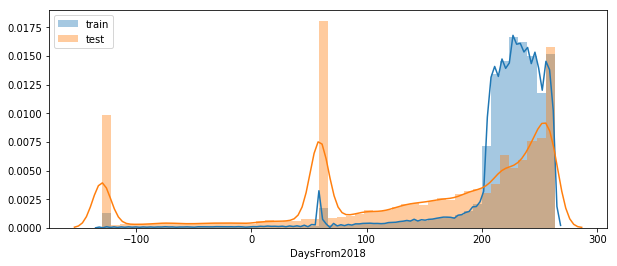

In [308]:
tools4kaggle.eda.train_test_dist(sample_df,test_df,'DaysFrom2018',disp_range=0.8)

### Census_InternalPrimaryDiagonalDisplaySizeInInches

ほぼ同一分布

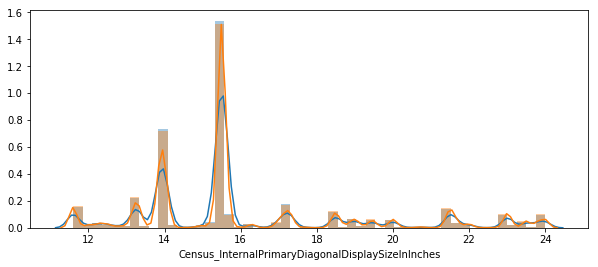

In [144]:
tools4kaggle.eda.train_test_dist(sample_df, test_df,'Census_InternalPrimaryDiagonalDisplaySizeInInches', disp_range=0.9)

### Census_TotalPhysicalRAM
ほぼ同一分布

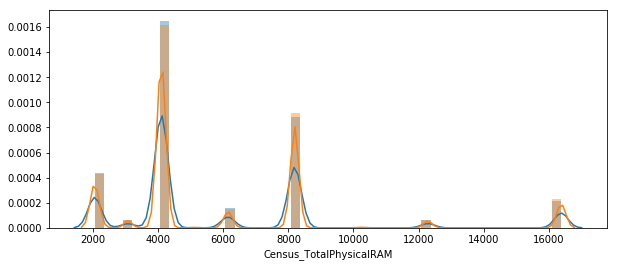

In [146]:
tools4kaggle.eda.train_test_dist(sample_df, test_df, 'Census_TotalPhysicalRAM', disp_range=0.9)

### LocaleEnglishNameIdentifier
結構違う．test の方が新しい．

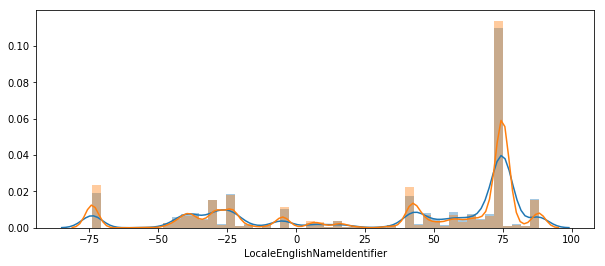

In [148]:
tools4kaggle.eda.train_test_dist(sample_df, test_df,'LocaleEnglishNameIdentifier',disp_range=0.8,bins=50)

### Census_OSBuildNumber

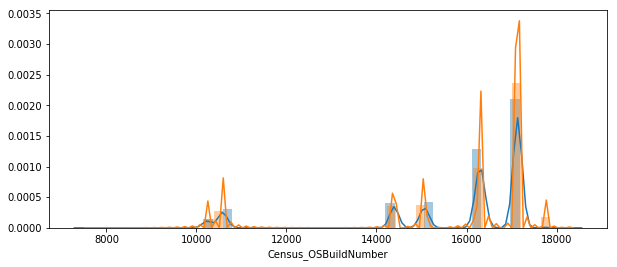

In [152]:
tools4kaggle.eda.train_test_dist(sample_df,test_df,'Census_OSBuildNumber')

### SmartScreen
あまり変わらない

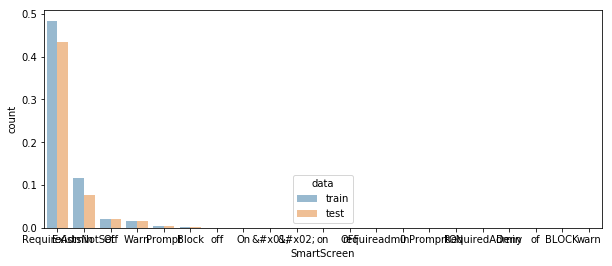

In [60]:
tools4kaggle.eda.train_test_dist(sample_df,test_df,'SmartScreen')

### Census_ProcessorCoreCount
あまり変わらない

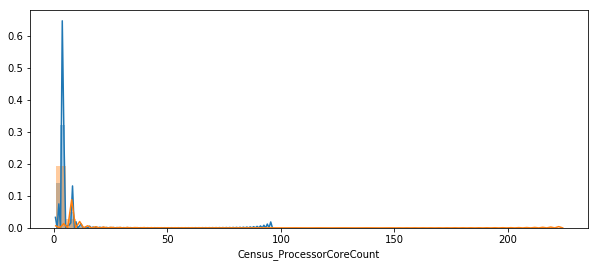

In [154]:
tools4kaggle.eda.train_test_dist(sample_df,test_df,'Census_ProcessorCoreCount')

### Census_OSBranch
少し差が出る．

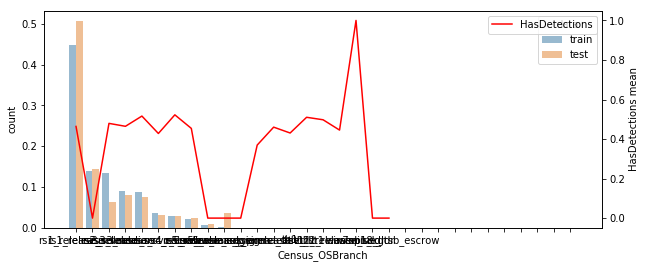

In [97]:
tools4kaggle.eda.train_test_dist(sample_df,test_df,'Census_OSBranch',target_name='HasDetections')

### OsBuildLab

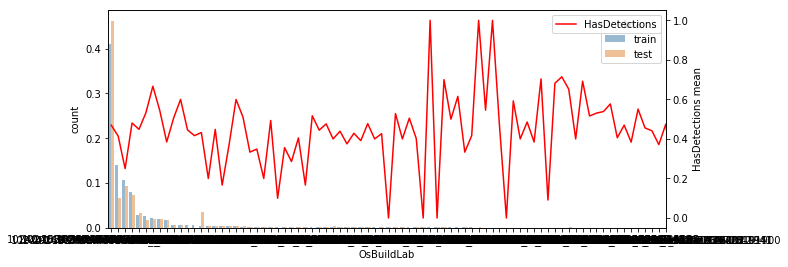

In [98]:
tools4kaggle.eda.train_test_dist(sample_df,test_df,'OsBuildLab',target_name='HasDetections',disp_num=80)

## Version 系

### OsVer
あまり変わらない．

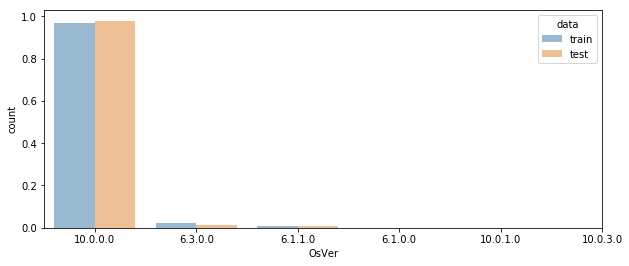

In [151]:
tools4kaggle.eda.train_test_dist(sample_df,test_df,'OsVer',disp_num=5)

### Census_OSVersion

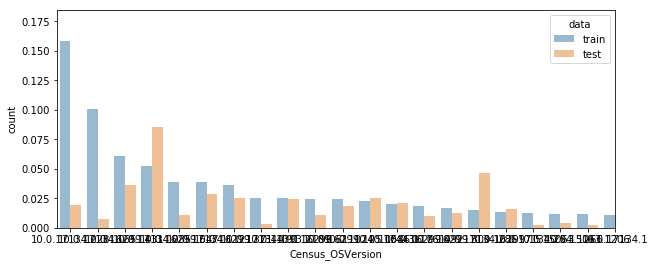

In [318]:
tools4kaggle.eda.train_test_dist(sample_df,test_df,'Census_OSVersion',disp_num=20)

In [185]:
version_df = sample_df.loc[:,['AppVersion','EngineVersion','AvSigVersion','Census_OSVersion']]

ve = tools4kaggle.transformer.VersionEncoder()
out = ve.fit_transform(version_df)

test_version_df = test_df.loc[:,['AppVersion','EngineVersion','AvSigVersion','Census_OSVersion']]
test_out = ve.transform(test_version_df)

### AppVersion

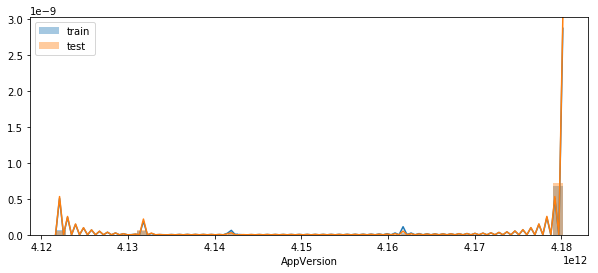

In [313]:
tools4kaggle.eda.train_test_dist(out, test_out, 'AppVersion',disp_range=0.7)

### EngineVersion

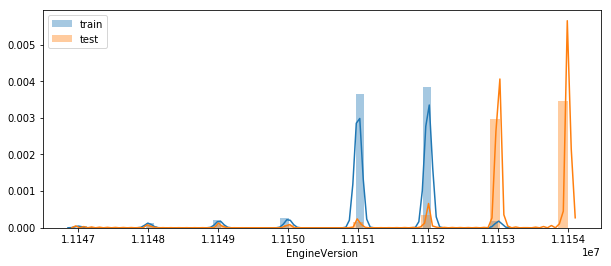

In [186]:
tools4kaggle.eda.train_test_dist(out, test_out, 'EngineVersion',disp_range=0.9)

### AvSigVersion

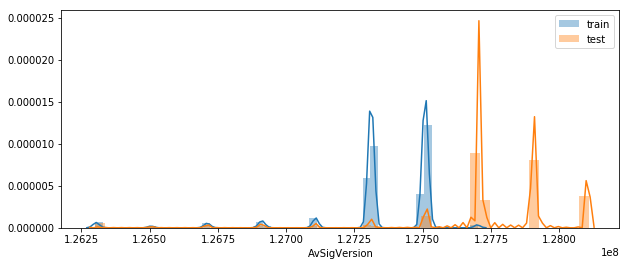

In [321]:
tools4kaggle.eda.train_test_dist(out, test_out, 'AvSigVersion',disp_range=0.9)

### Census_OSVersion

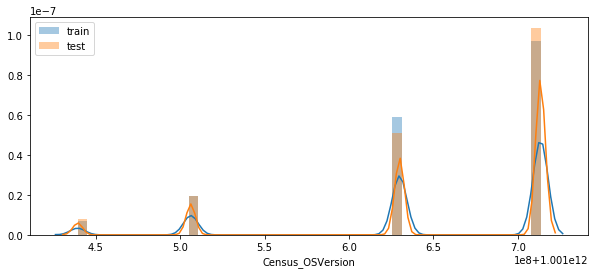

In [316]:
tools4kaggle.eda.train_test_dist(out, test_out, 'Census_OSVersion',disp_range=0.7)

## Identifier 系

In [ ]:
identifier_cols = [elem for elem in sample_df.columns  if 'Identifier' in elem]
id_describe = sample_df[identifier_cols].describe().T[['count','min','max']]
id_describe = id_describe.assign(count_na=sample_df.iloc[identifier

In [126]:
identifier_cols = [elem for elem in sample_df.columns  if 'Identifier' in elem]
sample_df[identifier_cols].describe().T[['count','min','max']] \
    .assign(count_na=sample_df[identifier_cols].isna().sum()) \
    .assign(unique=sample_df[identifier_cols].nunique()) \
    .assign(dtype=sample_df[identifier_cols].dtypes)

,count,min,max,count_na,unique,dtype
DefaultBrowsersIdentifier,43028.0,1.0,3204.0,849120,691,float16
AVProductStatesIdentifier,888489.0,6.0,70492.0,3659,7659,float32
CountryIdentifier,892148.0,1.0,222.0,0,222,int16
CityIdentifier,859590.0,5.0,167962.0,32558,48402,float32
OrganizationIdentifier,616460.0,1.0,52.0,275688,46,float16
GeoNameIdentifier,892131.0,1.0,296.0,17,271,float16
LocaleEnglishNameIdentifier,892148.0,-127.0,127.0,0,227,int8
IeVerIdentifier,886178.0,1.0,429.0,5970,206,float16
Census_OEMNameIdentifier,882776.0,1.0,6144.0,9372,1510,float16
Census_OEMModelIdentifier,882066.0,14.0,345494.0,10082,56352,float32


In [154]:
identifier_sample = sample_df[identifier_cols] \
    .applymap(lambda x:'id_{0}'.format(x) if not pd.isnull(x) else np.nan) \
    .astype('category') \
    .assign(HasDetections=sample_df.HasDetections)
identifier_test = test_df[identifier_cols] \
    .applymap(lambda x:'id_{0}'.format(x) if not pd.isnull(x) else np.nan) \
    .astype('category')

### DefaultBrowsersIdentifier

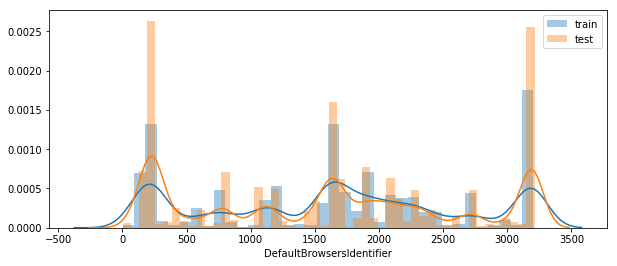

In [207]:
tools4kaggle.eda.train_test_dist(sample_df, test_df, 'DefaultBrowsersIdentifier')

### CountryIdentifier

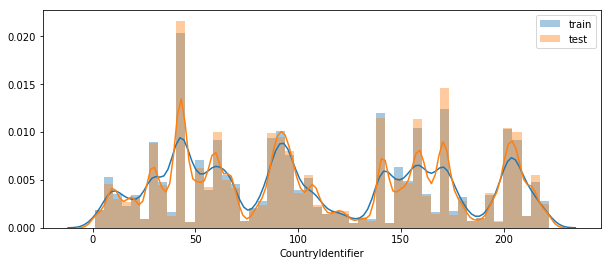

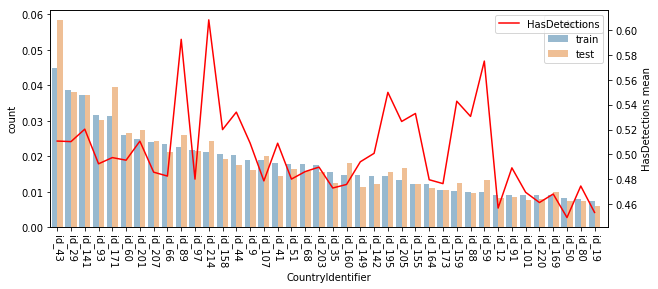

In [208]:
train_test_dist(sample_df, test_df, 'CountryIdentifier')
train_test_dist(identifier_sample, identifier_test, 'CountryIdentifier', target_name='HasDetections',disp_num=40)

### CityIdentifier

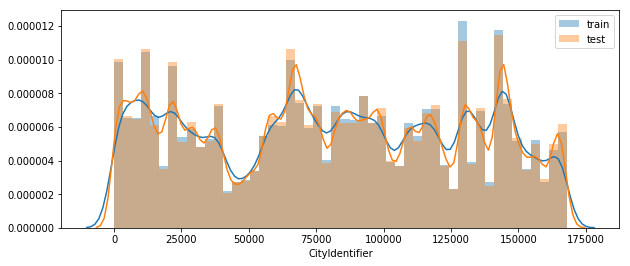

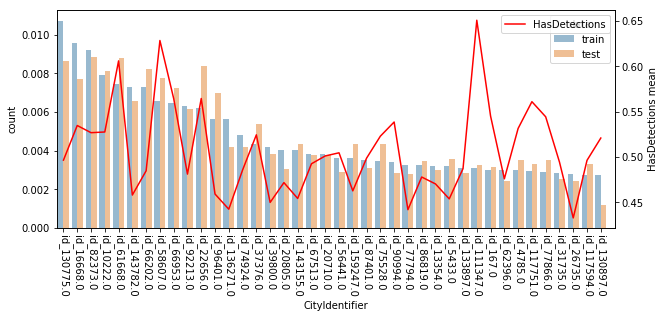

In [209]:
train_test_dist(sample_df, test_df, 'CityIdentifier')
train_test_dist(identifier_sample, identifier_test, 'CityIdentifier', target_name='HasDetections',disp_num=40)

### OrganizationIdentifier

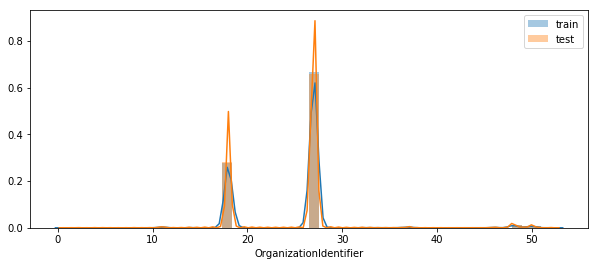

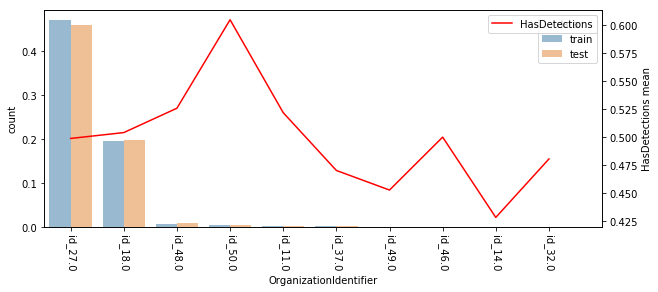

In [210]:
train_test_dist(sample_df, test_df, 'OrganizationIdentifier')
train_test_dist(identifier_sample, identifier_test, 'OrganizationIdentifier', target_name='HasDetections',disp_num=10)

### GeoNameIdentifier

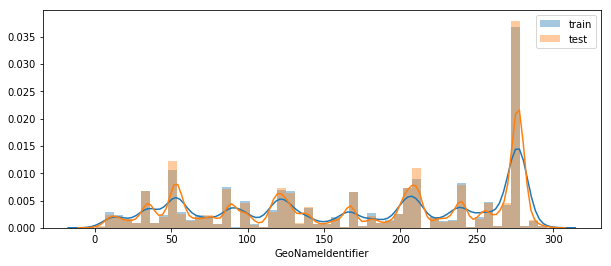

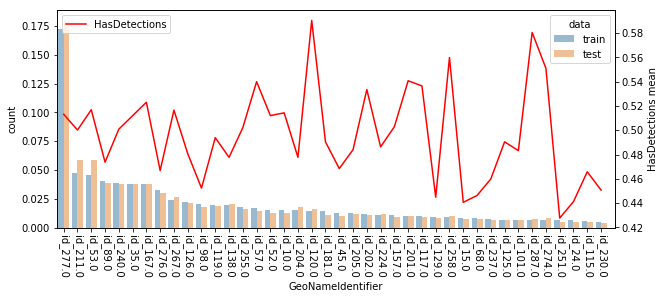

In [211]:
train_test_dist(sample_df, test_df, 'GeoNameIdentifier')
train_test_dist(identifier_sample, identifier_test, 'GeoNameIdentifier', target_name='HasDetections',disp_num=40)

### LocaleEnglishNameIdentifier
意味ありげクラス数が少ないうえに ratio が変動

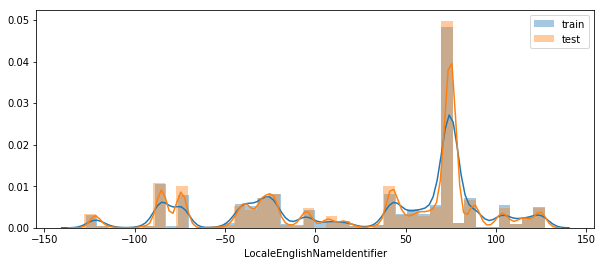

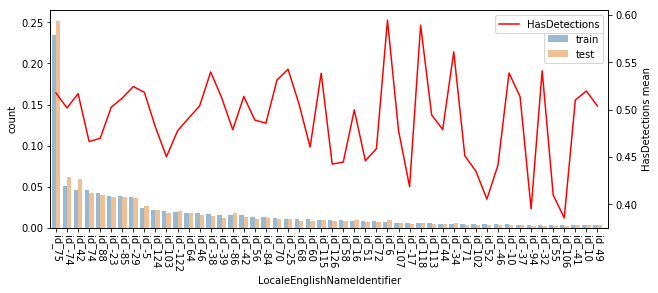

In [212]:
train_test_dist(sample_df, test_df, 'LocaleEnglishNameIdentifier',bins=40)
train_test_dist(identifier_sample, identifier_test, 'LocaleEnglishNameIdentifier', target_name='HasDetections',disp_num=50)

### IeVerIdentifier
これも意味ありげ．10 くらいまで？

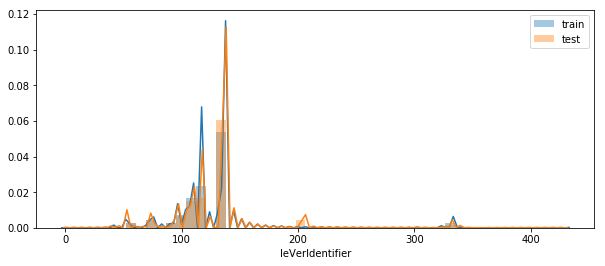

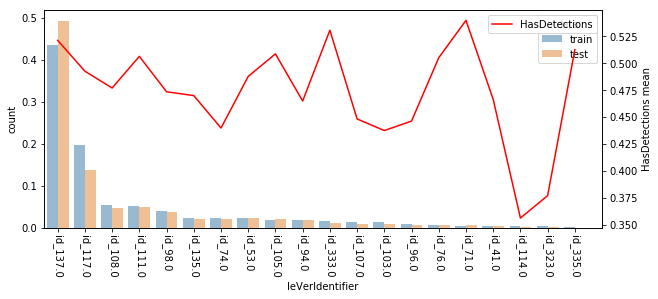

In [213]:
train_test_dist(sample_df, test_df, 'IeVerIdentifier')
train_test_dist(identifier_sample, identifier_test, 'IeVerIdentifier', target_name='HasDetections',disp_num=20)

### Census_OEMNameIdentifier

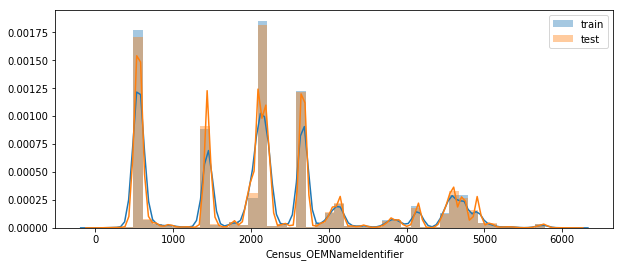

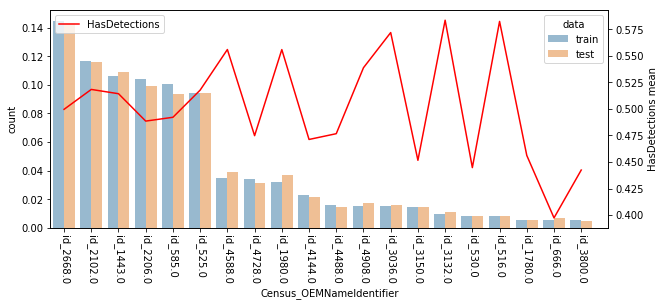

In [214]:
train_test_dist(sample_df, test_df, 'Census_OEMNameIdentifier')
train_test_dist(identifier_sample, identifier_test, 'Census_OEMNameIdentifier', target_name='HasDetections',disp_num=20)

# 特徴量エンジニアリング

基本的にはすべての特徴量を頻度エンコーディングする

In [146]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
import pickle

In [135]:
class FreqEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.encode_dicts = None
    
    def fit(self, X,y=None):
        """
        Create encoder Series for each column.
        
        Unknown is set to -1
        
        Parameters
        ----------
        X : Pandas.DataFrame
            Training data.
        y : None
            None
            
        Returns
        -------
        Trained encoder : self
            self.
        """
        self.encode_dicts = [X.iloc[:,i].value_counts() for i in range(X.shape[1])]
        for each_dict in self.encode_dicts:
            which_type = np.int8 if len(each_dict) < 128 \
                else np.int16 if len(each_dict) < pow(2,15) \
                else np.int32 if len(each_dict) < pow(2,31) \
                else np.int64
            each_dict[:] = np.arange(len(each_dict)).astype(which_type)
        return self
    
    def transform(self, X):
        ret_X = X.copy()
        for col_id in range(X.shape[1]):
            ret_X.iloc[:,col_id] = X.iloc[:,col_id].map(self.encode_dicts[col_id])
        ret_X.fillna(-1, inplace=True)
        return ret_X
    
    def predict(self, X):
        return X

In [190]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

# 学習

lightgbm を使って単一モデル学習

In [143]:
steps = [
    ('freq_encode', FreqEncoder()),
    ('lgbm', LGBMClassifier())
]
pipeline = Pipeline(steps=steps)

params = {
    'lgbm__max_depth':[-1, 4, 6],
    'lgbm__learning_rate':[0.01, 0.1, 0.3],
    'lgbm__colsample_bytree':[0.6]
}
grid_search_cv = GridSearchCV(
    pipeline, 
    param_grid=params, 
    scoring = 'roc_auc',
    n_jobs = 9,
    cv=3)

In [147]:
%%time

grid_search_cv.fit(
    sample_df.drop(['MachineIdentifier','HasDetections'], axis=1),
    sample_df.loc[:,'HasDetections']
)

with open('../tmp/tmp_model.pkl','wb') as f:
    pickle.dump(grid_search_cv, f)

CPU times: user 9h 17min 58s, sys: 29min 5s, total: 9h 47min 3s
Wall time: 16min 15s


### Grid search CV 結果

In [151]:
grid_search_cv.cv_results_['mean_test_score']

array([0.6887361 , 0.67661768, 0.68510759, 0.71093865, 0.69870312,
       0.70750228, 0.71551714, 0.70894729, 0.71511699])

### 全学習設定で学習

In [154]:
%%time
train_df = pd.read_parquet('../input/train.parquet')

CPU times: user 33.8 s, sys: 14.7 s, total: 48.5 s
Wall time: 21.8 s


In [169]:
%%time

fe = FreqEncoder()
encoded_df = fe.fit_transform(train_df)

CPU times: user 21min 56s, sys: 1min 36s, total: 23min 33s
Wall time: 4min


In [173]:
%%time
eval_split_df = encoded_df.iloc[:int(len(encoded_df) / 4), : ]
train_split_df = encoded_df.iloc[int(len(encoded_df) / 4):, :]

best_param = grid_search_cv.best_params_
lgbm = LGBMClassifier(n_estimators=1000, **best_param)

lgbm.fit(
    train_split_df.drop(['MachineIdentifier','HasDetections'], axis=1),
    train_split_df.loc[:,'HasDetections'],
    eval_set = \
        [(eval_split_df.drop(['MachineIdentifier','HasDetections'], axis=1), \
         eval_split_df.loc[:,'HasDetections'])],
    eval_metric = 'auc',
    early_stopping_rounds = 50
)

with open('../tmp/tmp_pp.pkl','wb') as f:
    pickle.dump(pipeline, f)

[1]	valid_0's auc: 0.670096	valid_0's binary_logloss: 0.683921
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's auc: 0.677336	valid_0's binary_logloss: 0.676115
[3]	valid_0's auc: 0.678126	valid_0's binary_logloss: 0.669788
[4]	valid_0's auc: 0.678908	valid_0's binary_logloss: 0.664536
[5]	valid_0's auc: 0.680471	valid_0's binary_logloss: 0.660029
[6]	valid_0's auc: 0.68087	valid_0's binary_logloss: 0.656312
[7]	valid_0's auc: 0.682576	valid_0's binary_logloss: 0.652964
[8]	valid_0's auc: 0.683295	valid_0's binary_logloss: 0.650219
[9]	valid_0's auc: 0.683857	valid_0's binary_logloss: 0.647876
[10]	valid_0's auc: 0.684529	valid_0's binary_logloss: 0.645772
[11]	valid_0's auc: 0.68516	valid_0's binary_logloss: 0.643893
[12]	valid_0's auc: 0.685597	valid_0's binary_logloss: 0.642341
[13]	valid_0's auc: 0.686321	valid_0's binary_logloss: 0.640977
[14]	valid_0's auc: 0.687031	valid_0's binary_logloss: 0.639709
[15]	valid_0's auc: 0.687413	valid_0's binary_logloss

[129]	valid_0's auc: 0.715894	valid_0's binary_logloss: 0.614699
[130]	valid_0's auc: 0.715985	valid_0's binary_logloss: 0.614636
[131]	valid_0's auc: 0.716045	valid_0's binary_logloss: 0.614589
[132]	valid_0's auc: 0.716104	valid_0's binary_logloss: 0.614543
[133]	valid_0's auc: 0.716196	valid_0's binary_logloss: 0.614477
[134]	valid_0's auc: 0.716263	valid_0's binary_logloss: 0.614427
[135]	valid_0's auc: 0.716354	valid_0's binary_logloss: 0.614362
[136]	valid_0's auc: 0.716419	valid_0's binary_logloss: 0.61431
[137]	valid_0's auc: 0.716486	valid_0's binary_logloss: 0.614258
[138]	valid_0's auc: 0.716547	valid_0's binary_logloss: 0.614203
[139]	valid_0's auc: 0.716657	valid_0's binary_logloss: 0.614116
[140]	valid_0's auc: 0.716743	valid_0's binary_logloss: 0.614046
[141]	valid_0's auc: 0.716818	valid_0's binary_logloss: 0.614
[142]	valid_0's auc: 0.716916	valid_0's binary_logloss: 0.613932
[143]	valid_0's auc: 0.71698	valid_0's binary_logloss: 0.613886
[144]	valid_0's auc: 0.717078	

[256]	valid_0's auc: 0.722534	valid_0's binary_logloss: 0.609584
[257]	valid_0's auc: 0.722562	valid_0's binary_logloss: 0.609564
[258]	valid_0's auc: 0.722604	valid_0's binary_logloss: 0.609533
[259]	valid_0's auc: 0.722616	valid_0's binary_logloss: 0.609522
[260]	valid_0's auc: 0.722635	valid_0's binary_logloss: 0.609506
[261]	valid_0's auc: 0.722689	valid_0's binary_logloss: 0.609461
[262]	valid_0's auc: 0.722721	valid_0's binary_logloss: 0.609429
[263]	valid_0's auc: 0.722778	valid_0's binary_logloss: 0.609383
[264]	valid_0's auc: 0.722812	valid_0's binary_logloss: 0.609358
[265]	valid_0's auc: 0.722837	valid_0's binary_logloss: 0.609338
[266]	valid_0's auc: 0.722875	valid_0's binary_logloss: 0.609309
[267]	valid_0's auc: 0.722905	valid_0's binary_logloss: 0.609285
[268]	valid_0's auc: 0.722934	valid_0's binary_logloss: 0.609262
[269]	valid_0's auc: 0.722978	valid_0's binary_logloss: 0.609235
[270]	valid_0's auc: 0.723023	valid_0's binary_logloss: 0.609199
[271]	valid_0's auc: 0.72

[383]	valid_0's auc: 0.725742	valid_0's binary_logloss: 0.607062
[384]	valid_0's auc: 0.725776	valid_0's binary_logloss: 0.607036
[385]	valid_0's auc: 0.725798	valid_0's binary_logloss: 0.607022
[386]	valid_0's auc: 0.725824	valid_0's binary_logloss: 0.606999
[387]	valid_0's auc: 0.725841	valid_0's binary_logloss: 0.606986
[388]	valid_0's auc: 0.725855	valid_0's binary_logloss: 0.606976
[389]	valid_0's auc: 0.725876	valid_0's binary_logloss: 0.606962
[390]	valid_0's auc: 0.725889	valid_0's binary_logloss: 0.606952
[391]	valid_0's auc: 0.725921	valid_0's binary_logloss: 0.606925
[392]	valid_0's auc: 0.725931	valid_0's binary_logloss: 0.606917
[393]	valid_0's auc: 0.725965	valid_0's binary_logloss: 0.606888
[394]	valid_0's auc: 0.726	valid_0's binary_logloss: 0.60686
[395]	valid_0's auc: 0.72602	valid_0's binary_logloss: 0.606842
[396]	valid_0's auc: 0.726046	valid_0's binary_logloss: 0.606823
[397]	valid_0's auc: 0.726059	valid_0's binary_logloss: 0.606814
[398]	valid_0's auc: 0.726069	

[510]	valid_0's auc: 0.727745	valid_0's binary_logloss: 0.605496
[511]	valid_0's auc: 0.727785	valid_0's binary_logloss: 0.605467
[512]	valid_0's auc: 0.727792	valid_0's binary_logloss: 0.605462
[513]	valid_0's auc: 0.727801	valid_0's binary_logloss: 0.605456
[514]	valid_0's auc: 0.72782	valid_0's binary_logloss: 0.605438
[515]	valid_0's auc: 0.72783	valid_0's binary_logloss: 0.605431
[516]	valid_0's auc: 0.727868	valid_0's binary_logloss: 0.605401
[517]	valid_0's auc: 0.727875	valid_0's binary_logloss: 0.605395
[518]	valid_0's auc: 0.727903	valid_0's binary_logloss: 0.605373
[519]	valid_0's auc: 0.727917	valid_0's binary_logloss: 0.605361
[520]	valid_0's auc: 0.727934	valid_0's binary_logloss: 0.60535
[521]	valid_0's auc: 0.727946	valid_0's binary_logloss: 0.605341
[522]	valid_0's auc: 0.727974	valid_0's binary_logloss: 0.605322
[523]	valid_0's auc: 0.727985	valid_0's binary_logloss: 0.605313
[524]	valid_0's auc: 0.727986	valid_0's binary_logloss: 0.60531
[525]	valid_0's auc: 0.728012

[637]	valid_0's auc: 0.729306	valid_0's binary_logloss: 0.604224
[638]	valid_0's auc: 0.729306	valid_0's binary_logloss: 0.604223
[639]	valid_0's auc: 0.729314	valid_0's binary_logloss: 0.604218
[640]	valid_0's auc: 0.729342	valid_0's binary_logloss: 0.604199
[641]	valid_0's auc: 0.729362	valid_0's binary_logloss: 0.604177
[642]	valid_0's auc: 0.72937	valid_0's binary_logloss: 0.604172
[643]	valid_0's auc: 0.729406	valid_0's binary_logloss: 0.60414
[644]	valid_0's auc: 0.729414	valid_0's binary_logloss: 0.604133
[645]	valid_0's auc: 0.729421	valid_0's binary_logloss: 0.604127
[646]	valid_0's auc: 0.729431	valid_0's binary_logloss: 0.60412
[647]	valid_0's auc: 0.729435	valid_0's binary_logloss: 0.604116
[648]	valid_0's auc: 0.729449	valid_0's binary_logloss: 0.604105
[649]	valid_0's auc: 0.729455	valid_0's binary_logloss: 0.604099
[650]	valid_0's auc: 0.729455	valid_0's binary_logloss: 0.604099
[651]	valid_0's auc: 0.729467	valid_0's binary_logloss: 0.604086
[652]	valid_0's auc: 0.72949

[764]	valid_0's auc: 0.73063	valid_0's binary_logloss: 0.603174
[765]	valid_0's auc: 0.730633	valid_0's binary_logloss: 0.603172
[766]	valid_0's auc: 0.730646	valid_0's binary_logloss: 0.603162
[767]	valid_0's auc: 0.730646	valid_0's binary_logloss: 0.603162
[768]	valid_0's auc: 0.730647	valid_0's binary_logloss: 0.60316
[769]	valid_0's auc: 0.730649	valid_0's binary_logloss: 0.603159
[770]	valid_0's auc: 0.730649	valid_0's binary_logloss: 0.603158
[771]	valid_0's auc: 0.730651	valid_0's binary_logloss: 0.603157
[772]	valid_0's auc: 0.730657	valid_0's binary_logloss: 0.603153
[773]	valid_0's auc: 0.730655	valid_0's binary_logloss: 0.603154
[774]	valid_0's auc: 0.730665	valid_0's binary_logloss: 0.603147
[775]	valid_0's auc: 0.730667	valid_0's binary_logloss: 0.603145
[776]	valid_0's auc: 0.730679	valid_0's binary_logloss: 0.603134
[777]	valid_0's auc: 0.730695	valid_0's binary_logloss: 0.603122
[778]	valid_0's auc: 0.730699	valid_0's binary_logloss: 0.603118
[779]	valid_0's auc: 0.7307

[891]	valid_0's auc: 0.731486	valid_0's binary_logloss: 0.60247
[892]	valid_0's auc: 0.731492	valid_0's binary_logloss: 0.602465
[893]	valid_0's auc: 0.731498	valid_0's binary_logloss: 0.60246
[894]	valid_0's auc: 0.731515	valid_0's binary_logloss: 0.602444
[895]	valid_0's auc: 0.731516	valid_0's binary_logloss: 0.602443
[896]	valid_0's auc: 0.731529	valid_0's binary_logloss: 0.602432
[897]	valid_0's auc: 0.73153	valid_0's binary_logloss: 0.60243
[898]	valid_0's auc: 0.731534	valid_0's binary_logloss: 0.602427
[899]	valid_0's auc: 0.731545	valid_0's binary_logloss: 0.60242
[900]	valid_0's auc: 0.731545	valid_0's binary_logloss: 0.602419
[901]	valid_0's auc: 0.731552	valid_0's binary_logloss: 0.602414
[902]	valid_0's auc: 0.731558	valid_0's binary_logloss: 0.602409
[903]	valid_0's auc: 0.731561	valid_0's binary_logloss: 0.602407
[904]	valid_0's auc: 0.731569	valid_0's binary_logloss: 0.602399
[905]	valid_0's auc: 0.73157	valid_0's binary_logloss: 0.602398
[906]	valid_0's auc: 0.731582	v

## 予測

In [ ]:
%%time
test_df = pd.read_parquet('../input/test.parquet')
encoded_test = fe.transform(test_df)

pred_score = lgbm.predict_proba(encoded_test.drop(['MachineIdentifier'], axis=1))

In [191]:
submission = test_df.iloc[:,[0]].copy()
submission['HasDetections'] = pred_score[:,1]
submission.to_csv('../result/single_lgbm.csv',index=False)

In [182]:
pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [189]:
reduce_mem_usage(encoded_df)

NameError: name 'reduce_mem_usage' is not defined